In [2]:
import sys
sys.path.append("../")
import numpy as np
import pandas as pd
from scipy import stats
from dataclasses import dataclass
from typing import Tuple, Dict

# Import your custom modules
from plume_sim_batch import COSMOSBatch
import odor_stat_calculations as osc  # Your odor statistics calculator

from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
from scipy.stats import wasserstein_distance
from cfd_rigolli import Cfd_rigolli_BDCATS

%load_ext autoreload
%autoreload 2


2025-05-14 09:21:01.620317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 09:21:01.631195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 09:21:01.634447: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 09:21:02.288445: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)


# cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")
# # Check the scaled range of x_coords and y_coords
# x_coords = cfd.x_coords
# y_coords = cfd.y_coords

# print("Scaled x-coords range:", x_coords.min(), x_coords.max())
# print("Scaled y-coords range:", y_coords.min(), y_coords.max())


In [47]:
from tqdm import tqdm
import seaborn as sns
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def bootstrap_wasserstein_2d(x_true, y_true, x_pred, y_pred, n_bootstraps=1000):
    """
    Bootstrap the Wasserstein distance between two 2D distributions
    using resampling with replacement (using flattened histograms as an approximation).
    """
    distances = []

    # Get the original data sizes
    n_true = len(x_true)
    n_pred = len(x_pred)

    # Define bins once for consistent comparison across bootstraps
    x_bins_orig = np.linspace(min(x_true.min(), x_pred.min()), max(x_true.max(), x_pred.max()), 30)
    y_bins_orig = np.linspace(min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max()), 30)

    # Use density=True, which normalizes the histogram to sum to 1
    true_hist_orig, _, _ = np.histogram2d(x_true, y_true, bins=[x_bins_orig, y_bins_orig], density=True)
    pred_hist_orig, _, _ = np.histogram2d(x_pred, y_pred, bins=[x_bins_orig, y_bins_orig], density=True)

    # Flatten and compute Wasserstein Distance (using 1D WD as approximation)
    observed_wd = wasserstein_distance(true_hist_orig.flatten(), pred_hist_orig.flatten())

    for _ in tqdm(range(n_bootstraps)):
        # Resample with replacement from the original data
        true_indices = np.random.choice(n_true, size=n_true, replace=True)
        pred_indices = np.random.choice(n_pred, size=n_pred, replace=True)

        # Handle both pandas Series/DataFrame and numpy arrays
        if hasattr(x_true, 'iloc'):  # pandas
            x_true_resampled = x_true.iloc[true_indices]
            y_true_resampled = y_true.iloc[true_indices]
        else:  # numpy
            x_true_resampled = x_true[true_indices]
            y_true_resampled = y_true[true_indices]

        if hasattr(x_pred, 'iloc'):  # pandas
            x_pred_resampled = x_pred.iloc[pred_indices]
            y_pred_resampled = y_pred.iloc[pred_indices]
        else:  # numpy
            x_pred_resampled = x_pred[pred_indices]
            y_pred_resampled = y_pred[pred_indices]

        # Use the same bins as the original to ensure fair comparison
        true_hist, _, _ = np.histogram2d(x_true_resampled, y_true_resampled,
                                       bins=[x_bins_orig, y_bins_orig], density=True)
        pred_hist, _, _ = np.histogram2d(x_pred_resampled, y_pred_resampled,
                                       bins=[x_bins_orig, y_bins_orig], density=True)

        # Flatten and compute Wasserstein Distance (using 1D WD as approximation)
        distance = wasserstein_distance(true_hist.flatten(), pred_hist.flatten())
        distances.append(distance)

    return observed_wd, distances, true_hist_orig, pred_hist_orig, x_bins_orig, y_bins_orig

def wd_cal(x_true, y_true, x_pred, y_pred, label1, vmin, vmax):
    # Calculate the observed Wasserstein distance, bootstrap distribution, and get histograms
    observed_wd_2d, bootstrap_distances, true_hist, pred_hist, x_bins, y_bins = bootstrap_wasserstein_2d(
        x_true, y_true, x_pred, y_pred, 1000
    )

    # Calculate p-value
    p_value = np.mean(np.array(bootstrap_distances) >= observed_wd_2d)

    # Plot results with the histograms calculated in bootstrap_wasserstein_2d
    plot_wd(bootstrap_distances, observed_wd_2d, p_value, true_hist, pred_hist, label1, vmin, vmax)

    return observed_wd_2d, p_value

def plot_wd(bootstrap_distances, observed_wd_2d, p_value, true_hist, pred_hist, label1, vmin=None, vmax=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

    # Plot 1: Actual data heatmap (using density=True normalized histogram)
    sns.heatmap(true_hist.T, ax=ax1, cmap='Blues', cbar_kws={'label': 'Density'}, vmin=vmin, vmax=vmax, xticklabels=[], yticklabels=[])

    ax1.invert_yaxis()
    ax1.set_title('Actual Data Density')
    ax1.set_xlabel('Distance from Source')
    ax1.set_ylabel(label1)

    # Plot 2: Predicted data heatmap (using density=True normalized histogram)
    sns.heatmap(pred_hist.T, ax=ax2, cmap='Reds', cbar_kws={'label': 'Density'}, vmin=vmin, vmax=vmax, xticklabels=[], yticklabels=[])

    ax2.invert_yaxis()
    ax2.set_title('Predicted Data Density')
    ax2.set_xlabel('Distance from Source')
    ax2.set_ylabel(label1)

    # Plot 3: Histogram with bootstrap distribution
    sns.histplot(bootstrap_distances, bins=30, kde=True, color='blue', edgecolor='slategray', linewidth=1.5, ax=ax3)
    ax3.axvline(observed_wd_2d, color='red', linestyle='--', linewidth=2, label=f'Wd$_{{obs}}$\n(p-value={p_value:.3f})')
    ax3.set_title('Bootstrap Distribution')
    ax3.set_xlabel('Wasserstein Distance (Wd)')
    ax3.set_ylabel('Frequency')
    ax3.legend(loc='upper right')

    # Adjust layout
    fig.tight_layout()



In [53]:
def scale_data(arr):
    """Simple min‑max scaling to 0–10 a.u. for visual comparability."""
    arr = np.asarray(arr, dtype=float)
    return 10 * (arr - arr.min()) / (arr.max() - arr.min() + 1e-12)


# Original statistics calculation functions
def avg_distance(df, index, dat):  # input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i < len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i += 1
    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline


def get_index_nowhiff(data, th):
    from itertools import groupby
    from operator import itemgetter
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index


def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)
    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline


def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)
    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

In [57]:
DATA_DIR = "../data/simulator/rigolli/"
TRAJ_FILE = DATA_DIR + "rigolli_jan22.h5"   # base trajectory (200 Hz, regular speed)
HMAP_FILE = DATA_DIR + "hmap.npz"
CFD_DIR = "../data/rigolli/"              # directory used by Cfd_rigolli_BDCATS
WHIFF_TH = 6.5     # threshold (a.u.) for Rigolli data set
FAST_X = 20      # factor by which to speed up the fast trajectory
DIST_WIN = 3.0     # first N metres to display in time‑series panels
N_BOOT = 500     # bootstrap iterations for null distribution
np.random.seed(0)    # reproducibility for reviewer

# -----------------------------------------------------------------------------
#  1.  helper functions
# -----------------------------------------------------------------------------

# def resample_traj(df: pd.DataFrame, speed_factor: float, dt_base: float) -> pd.DataFrame:
#     """Return *same* spatial trajectory with rescaled sampling period."""
#     new_dt = dt_base / speed_factor
#     n = len(df)
#     new_time = np.arange(0, n * new_dt, new_dt)[:n]
#     out = df.copy()
#     out["time"] = new_time
#     return out

# keep dt_base = 1/200
# build a “fast” traj so that at each dt_base the agent is 5× farther

def resample_traj(df, speed_factor, dt_base):
    orig_t = df.time.values
    orig_x = df.distance_along_streakline.values
    orig_y = df.nearest_from_streakline.values

    new_t = np.arange(len(df)) * dt_base
    sample_t = orig_t[0] + new_t * speed_factor

    new_x = np.interp(sample_t, orig_t, orig_x)
    new_y = np.interp(sample_t, orig_t, orig_y)

    return pd.DataFrame({
      "time": new_t,
      "distance_along_streakline": new_x,
      "nearest_from_streakline": new_y
    })

# then run CFD & COSMOS on that “fast” traj at dt=0.005 s


def run_cfd(traj: pd.DataFrame, cfd) -> pd.DataFrame:
    """Query CFD simulator at each (x,y,t) in *traj* → scaled odor trace."""
    odor = [
        cfd.get_odor_at_position_and_time((x, y), t)
        for (x, y), t in zip(
            traj[["distance_along_streakline", "nearest_from_streakline"]].values,
            traj.time.values,
        )
    ]
    df = traj.copy()
    df["odor"] = scale_data(odor)  # same scaling helper used for COSMOS
    return df


def scale_data(arr):
    """Simple min‑max scaling to 0–10 a.u. for visual comparability."""
    arr = np.asarray(arr, dtype=float)
    return 10 * (arr - arr.min()) / (arr.max() - arr.min() + 1e-12)


# Original statistics calculation functions
def avg_distance(df, index, dat):  # input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i < len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i += 1
    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline


def get_index_nowhiff(data, th):
    from itertools import groupby
    from operator import itemgetter
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index


def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)
    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline


def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)
    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff


def compute_whiff_stats(df: pd.DataFrame, th: float):
    """Return DataFrame with whiff statistics using original functions."""
    idx_whiff = osc.get_index(df.odor, th)
    idx_nowh = get_index_nowhiff(df.odor, th)

    fdf, fdf_nowh = pd.DataFrame(), pd.DataFrame()
    
    # Use your original functions
    osc.avg_distance(df, idx_whiff, fdf)
    osc.mean_conc(df, idx_whiff, fdf)
    osc.whiff_blank_duration(df, idx_whiff, fdf)
    osc.std_whiff(df, idx_whiff, fdf)
    osc.mean_avg(df, idx_whiff, fdf)
    osc.encounter_frequency(df, idx_whiff, fdf, 1, 2)
    osc.mean_t(df, idx_whiff, fdf)
    
    # Use your avg_distance function instead of osc.avg_distance
    avg_distance(df, idx_whiff, fdf)
    
    # Stats in blanks
    avg_distance_nowhiff(df, idx_nowh, fdf_nowh)
    wc_wsd_nowhiff(df, idx_nowh, fdf_nowh)

    out = pd.concat([fdf, fdf_nowh], axis=1)
    return out


def wd_2d(x_true, y_true, x_pred, y_pred):
    """2‑D Wasserstein distance on normalised 2‑D histograms."""
    x_bins = np.linspace(min(x_true.min(), x_pred.min()), max(x_true.max(), x_pred.max()), 30)
    y_bins = np.linspace(min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max()), 30)

    true_hist, _, _ = np.histogram2d(x_true, y_true, bins=[x_bins, y_bins], density=True)
    pred_hist, _, _ = np.histogram2d(x_pred, y_pred, bins=[x_bins, y_bins], density=True)
    true_hist = true_hist / (true_hist.max() + 1e-12)
    pred_hist = pred_hist / (pred_hist.max() + 1e-12)

    return wasserstein_distance(true_hist.ravel(), pred_hist.ravel())


def compute_wd(stats_cfd, stats_cosmos):
    """Compute Wasserstein distances for all metrics."""
    out = {}
    for name, (xcol, ycol) in METRICS.items():
        out[name] = wd_2d(stats_cfd[xcol], stats_cfd[ycol], stats_cosmos[xcol], stats_cosmos[ycol])
    out["SUM"] = sum(out.values())
    return out


# -----------------------------------------------------------------------------
#  2.  load trajectory & heat‑map data
# -----------------------------------------------------------------------------
print("Loading data...")
traj_ref = pd.read_hdf(TRAJ_FILE)[:200]
hmap_data = np.load(HMAP_FILE)

# Normalize time to 0–170 s (makes resampling easy but not essential)
traj_ref = traj_ref.copy() # Limit trajectory length for faster computation
T = traj_ref.time.max() - traj_ref.time.min()
traj_ref["time"] = (traj_ref.time - traj_ref.time.min()) / T * 170

# Base sampling period (≈ 0.005 s)
dt_base = traj_ref.time.diff().median()

# -----------------------------------------------------------------------------
#  3.  Generate trajectories and CFD ground truth
# -----------------------------------------------------------------------------
print("Building CFD simulator & generating trajectories...")
cfd = Cfd_rigolli_BDCATS(dirname=CFD_DIR)

# Generate the two trajectories
traj_slow = traj_ref.copy()                     # 1× speed (original)
traj_fast = resample_traj(traj_ref, FAST_X, dt_base)  # 100× speed

# Get ground truth from CFD for both trajectories
df_cfd_slow = run_cfd(traj_slow, cfd)
df_cfd_fast = run_cfd(traj_fast, cfd)

# -----------------------------------------------------------------------------
#  4.  Use precomputed statistics files for COSMOS
# -----------------------------------------------------------------------------
print("Loading precomputed statistics...")

# Load the precomputed statistics files
fdf_slow = pd.read_hdf(str(DATA_DIR) + 'whiff.h5')
fdf_nowhiff_slow = pd.read_hdf(str(DATA_DIR) + 'nowhiff.h5')

# -----------------------------------------------------------------------------
#  5.  Run the two experimental conditions
# -----------------------------------------------------------------------------
print("Running two experimental conditions...")

# Case 1: Slow trajectory with slow-trained model (matched)
predictor_slow_matched = COSMOSBatch(
    fitted_p_heatmap=hmap_data["fitted_p_heatmap"],
    xedges=hmap_data["xedges"],
    yedges=hmap_data["yedges"],
    fdf=fdf_slow,
    fdf_nowhiff=fdf_nowhiff_slow,
    test_locations=traj_slow[["distance_along_streakline", "nearest_from_streakline"]].values
)
result_slow_matched = predictor_slow_matched.predict()
df_cosmos_slow_matched = traj_slow.copy()
df_cosmos_slow_matched["odor"] = scale_data(result_slow_matched["concentrations"])
df_cosmos_slow_matched["whiff"] = result_slow_matched["predictions"].astype(bool)

# Case 2: Fast trajectory with slow-trained model (mismatched)
predictor_fast_mismatched = COSMOSBatch(
    fitted_p_heatmap=hmap_data["fitted_p_heatmap"],
    xedges=hmap_data["xedges"],
    yedges=hmap_data["yedges"],
    fdf=fdf_slow,
    fdf_nowhiff=fdf_nowhiff_slow,
    test_locations=traj_fast[["distance_along_streakline", "nearest_from_streakline"]].values
)
result_fast_mismatched = predictor_fast_mismatched.predict()
df_cosmos_fast_mismatched = traj_fast.copy()
df_cosmos_fast_mismatched["odor"] = scale_data(result_fast_mismatched["concentrations"])
df_cosmos_fast_mismatched["whiff"] = result_fast_mismatched["predictions"].astype(bool)

# -----------------------------------------------------------------------------
#  6.  Compute statistics & wasserstein distances
# -----------------------------------------------------------------------------
print("Computing whiff statistics...")

# Metrics to compare
METRICS = {
    "WF": ("log_avg_dist_from_source", "wf"),
    "WD": ("log_avg_dist_from_source", "log_whiff"),
    "WC": ("log_avg_dist_from_source", "mean_concentration"),
    "WSD": ("log_avg_dist_from_source", "std_whiff"),
    "WMA": ("log_avg_dist_from_source", "whiff_ma"),
}

# Compute statistics for both cases
stats_cfd_slow = compute_whiff_stats(df_cfd_slow, WHIFF_TH)
stats_cosmos_slow_matched = compute_whiff_stats(df_cosmos_slow_matched, WHIFF_TH)

stats_cfd_fast = compute_whiff_stats(df_cfd_fast, WHIFF_TH)
stats_cosmos_fast_mismatched = compute_whiff_stats(df_cosmos_fast_mismatched, WHIFF_TH)

# Calculate Wasserstein distances
wd_slow_matched = compute_wd(stats_cfd_slow, stats_cosmos_slow_matched)
wd_fast_mismatched = compute_wd(stats_cfd_fast, stats_cosmos_fast_mismatched)



Loading data...
Building CFD simulator & generating trajectories...


KeyboardInterrupt: 

In [62]:

# -----------------------------------------------------------------------------
#  Constants & paths
# -----------------------------------------------------------------------------
DATA_DIR    = "../data/simulator/rigolli/"
TRAJ_FILE   = DATA_DIR + "rigolli_jan22.h5"
HMAP_FILE   = DATA_DIR + "hmap.npz"
CFD_DIR     = "../data/rigolli/"
WHIFF_TH    = 6.5      # threshold (a.u.)
FAST_X      = 20       # speed‐up factor
N_BOOT      = 500
np.random.seed(0)

# -----------------------------------------------------------------------------
#  1.  Helper functions
# -----------------------------------------------------------------------------
def accelerate_traj(df: pd.DataFrame,
                    speed_factor: float,
                    dt_base: float) -> pd.DataFrame:
    """
    Keep all original columns, but:
      - set time[i] = i * dt_base
      - re-sample distance_along_streakline & nearest_from_streakline
        so that the agent moves speed_factor× faster.
    """
    out = df.copy()
    orig_t = df.time.values
    x = df.distance_along_streakline.values
    y = df.nearest_from_streakline.values

    N = len(df)
    new_t    = np.arange(N) * dt_base
    sample_t = orig_t[0] + new_t * speed_factor
    sample_t = np.clip(sample_t, orig_t[0], orig_t[-1])

    out["time"]                     = new_t
    out["distance_along_streakline"] = np.interp(sample_t, orig_t, x)
    out["nearest_from_streakline"]   = np.interp(sample_t, orig_t, y)

    return out


def run_cfd(traj: pd.DataFrame, cfd) -> pd.DataFrame:
    """Query CFD at each (x,y,t) and scale to 0–10 a.u."""
    odor = [
        cfd.get_odor_at_position_and_time((x, y), t)
        for (x, y), t in zip(
            traj[["distance_along_streakline", "nearest_from_streakline"]].values,
            traj.time.values,
        )
    ]
    df = traj.copy()
    df["odor"] = scale_data(odor)
    return df


def scale_data(arr):
    arr = np.asarray(arr, dtype=float)
    return 10 * (arr - arr.min()) / (arr.max() - arr.min() + 1e-12)


def whiff_durations(df: pd.DataFrame, idx_whiff: list) -> np.ndarray:
    """Compute each whiff episode’s duration in seconds."""
    durs = []
    for indices in idx_whiff:
        if not indices:
            durs.append(0.0)
        else:
            t0 = df.time.iloc[indices[0]]
            t1 = df.time.iloc[indices[-1]]
            durs.append(t1 - t0)
    return np.array(durs)


def blank_durations(df: pd.DataFrame, idx_blank: list) -> np.ndarray:
    """Compute each blank episode’s duration in seconds."""
    durs = []
    for indices in idx_blank:
        if not indices:
            durs.append(0.0)
        else:
            t0 = df.time.iloc[indices[0]]
            t1 = df.time.iloc[indices[-1]]
            durs.append(t1 - t0)
    return np.array(durs)


def get_index_nowhiff(data, th):
    from itertools import groupby
    from operator import itemgetter
    idx = [i for i, v in enumerate(data) if v < th]
    return [list(map(itemgetter(1), g))
            for _, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]


def compute_whiff_stats(df: pd.DataFrame, th: float) -> pd.DataFrame:
    """
    Returns a DataFrame with:
      • spatial stats (avg_distance, mean_conc, std_whiff, mean_avg, encounter_frequency, mean_t)
      • whiff_duration_s, blank_duration_s
      • blank spatial & concentration stats (avg_distance_nowhiff, wc_wsd_nowhiff)
    """
    idx_whiff = osc.get_index(df.odor, th)
    idx_blank = get_index_nowhiff(df.odor, th)

    fdf       = pd.DataFrame()
    fdf_blank = pd.DataFrame()

    # spatial & concentration stats during whiffs
    osc.avg_distance(df,    idx_whiff, fdf)
    osc.mean_conc(df,       idx_whiff, fdf)
    osc.std_whiff(df,       idx_whiff, fdf)
    osc.mean_avg(df,        idx_whiff, fdf)
    osc.encounter_frequency(df, idx_whiff, fdf, 1, 2)
    osc.mean_t(df,          idx_whiff, fdf)

    # add real‐time durations
    fdf["whiff_duration_s"] = whiff_durations(df, idx_whiff)

    # blank‐episode stats
    avg_distance_nowhiff(df, idx_blank, fdf_blank)
    wc_wsd_nowhiff(df,       idx_blank, fdf_blank)
    fdf_blank["blank_duration_s"] = blank_durations(df, idx_blank)

    return pd.concat([fdf, fdf_blank], axis=1)


def wd_2d(x_true, y_true, x_pred, y_pred):
    x_bins = np.linspace(
        min(x_true.min(), x_pred.min()),
        max(x_true.max(), x_pred.max()),
        30
    )
    y_bins = np.linspace(
        min(y_true.min(), y_pred.min()),
        max(y_true.max(), y_pred.max()),
        30
    )
    t_hist, _, _ = np.histogram2d(x_true, y_true, bins=[x_bins, y_bins], density=True)
    p_hist, _, _ = np.histogram2d(x_pred, y_pred, bins=[x_bins, y_bins], density=True)
    t_hist /= t_hist.max() + 1e-12
    p_hist /= p_hist.max() + 1e-12
    return wasserstein_distance(t_hist.ravel(), p_hist.ravel())


def compute_wd(stats_cfd: pd.DataFrame, stats_cosmos: pd.DataFrame) -> dict:
    out = {}
    for name, (xcol, ycol) in METRICS.items():
        out[name] = wd_2d(
            stats_cfd[xcol], stats_cfd[ycol],
            stats_cosmos[xcol], stats_cosmos[ycol]
        )
    out["SUM"] = sum(out.values())
    return out

# -----------------------------------------------------------------------------
#  2.  Load & normalize trajectory
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
#  2.  Load & truncate trajectory to CFD window
# -----------------------------------------------------------------------------
print("Loading data…")
traj_ref = pd.read_hdf(TRAJ_FILE)    # full 200 Hz data
hmap_data = np.load(HMAP_FILE)

# confirm your sensor cadence
dt_base = traj_ref.time.diff().median()
assert abs(dt_base - 0.005) < 1e-4, f"dt_base = {dt_base:.4f}, want ~0.005"

# build the CFD simulator
cfd = Cfd_rigolli_BDCATS(dirname=CFD_DIR)

# -------------- HERE: find the CFD's max time --------------
# Option A: if the Cfd object exposes its time grid:
#     max_time = cfd.time_grid.max()
# Option B: if not, infer from its number of time samples:
n_cfd_steps = cfd.odor.shape[0]     # e.g. 2 600
max_time    = (n_cfd_steps - 1) * dt_base # ≃ 12.995 s
# ------------------------------------------------------------

# truncate your traj_ref so no time exceeds max_time
traj_ref = traj_ref[traj_ref.time <= max_time].reset_index(drop=True)

print(f"Using {len(traj_ref)} samples spanning 0–{max_time:.3f}s for both CFD & COSMOS")

# -----------------------------------------------------------------------------
#  3.  Generate CFD ground truth
# -----------------------------------------------------------------------------
print("Building CFD & generating trajectories…")
cfd = Cfd_rigolli_BDCATS(dirname=CFD_DIR)

traj_slow = traj_ref.copy()                                # 1×
traj_fast = accelerate_traj(traj_ref, FAST_X, dt_base)     # FAST_X×

df_cfd_slow = run_cfd(traj_slow, cfd)
df_cfd_fast = run_cfd(traj_fast, cfd)

# -----------------------------------------------------------------------------
#  4.  Load COSMOS stats & run predictions
# -----------------------------------------------------------------------------
print("Loading precomputed COSMOS stats…")
fdf_slow         = pd.read_hdf(f"{DATA_DIR}whiff.h5")
fdf_nowhiff_slow = pd.read_hdf(f"{DATA_DIR}nowhiff.h5")

METRICS = {
    "WF":  ("log_avg_dist_from_source", "wf"),
    "WD":  ("log_avg_dist_from_source", "log_whiff"),
    "WC":  ("log_avg_dist_from_source", "mean_concentration"),
    "WSD": ("log_avg_dist_from_source", "std_whiff"),
    "WMA": ("log_avg_dist_from_source", "whiff_ma"),
}

def run_cosmos(fdf, fdf_now, traj):
    predictor = COSMOSBatch(
        fitted_p_heatmap = hmap_data["fitted_p_heatmap"],
        xedges           = hmap_data["xedges"],
        yedges           = hmap_data["yedges"],
        fdf              = fdf,
        fdf_nowhiff      = fdf_now,
        test_locations   = traj[["distance_along_streakline","nearest_from_streakline"]].values
    )
    res = predictor.predict()
    df = traj.copy()
    df["odor"]  = scale_data(res["concentrations"])
    df["whiff"] = res["predictions"].astype(bool)
    return df

df_cosmos_slow = run_cosmos(fdf_slow, fdf_nowhiff_slow, traj_slow)
df_cosmos_fast = run_cosmos(fdf_slow, fdf_nowhiff_slow, traj_fast)

# -----------------------------------------------------------------------------
#  5.  Compute stats & Wasserstein distances
# -----------------------------------------------------------------------------
print("Computing whiff statistics & Wasserstein distances…")
stats_cfd_slow    = compute_whiff_stats(df_cfd_slow,    WHIFF_TH)
stats_cosmos_slow = compute_whiff_stats(df_cosmos_slow, WHIFF_TH)
stats_cfd_fast    = compute_whiff_stats(df_cfd_fast,    WHIFF_TH)
stats_cosmos_fast = compute_whiff_stats(df_cosmos_fast, WHIFF_TH)

wd_slow_matched  = compute_wd(stats_cfd_slow,    stats_cosmos_slow)
wd_fast_mismatch = compute_wd(stats_cfd_fast,    stats_cosmos_fast)

print("WD slow–matched: ", wd_slow_matched)
print("WD fast–mismatched:", wd_fast_mismatch)


Loading data…


AttributeError: 'Cfd_rigolli_BDCATS' object has no attribute 'odor'

100%|██████████| 1000/1000 [00:01<00:00, 743.28it/s]


(0.017770632760161623, 0.192)

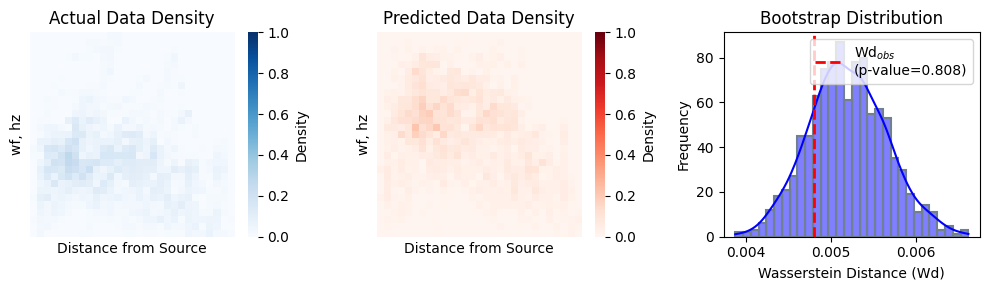

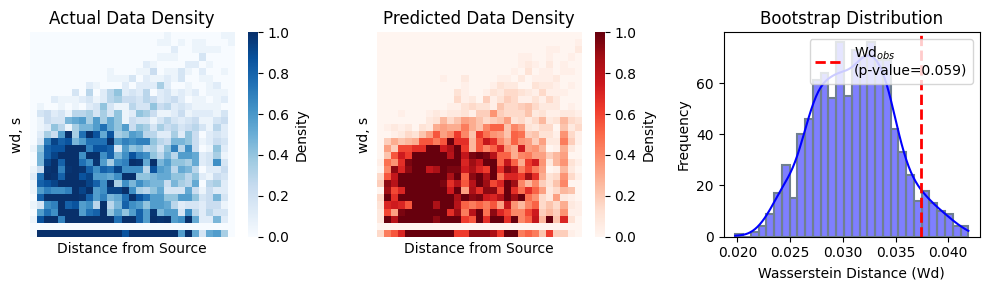

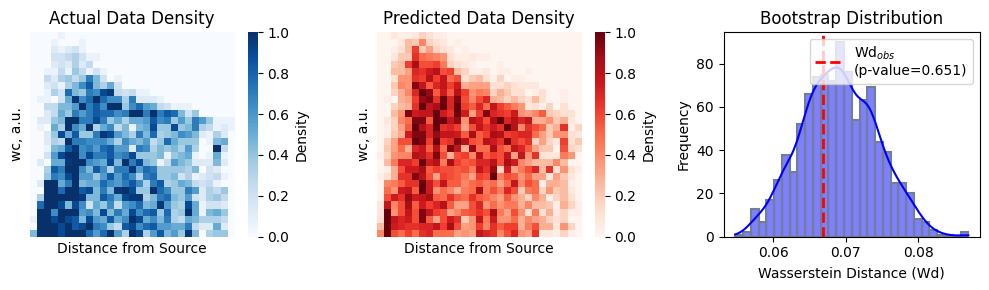

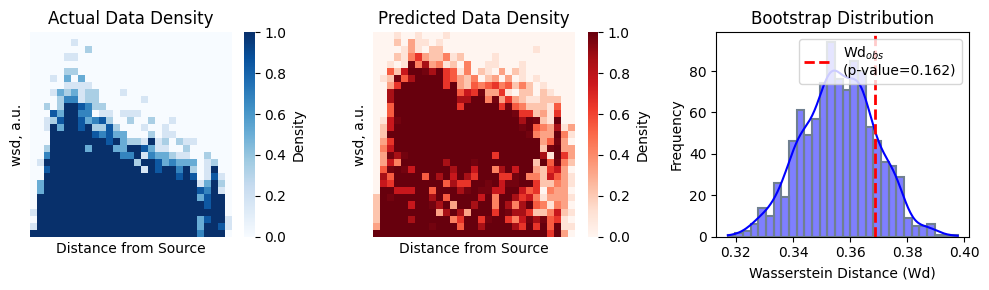

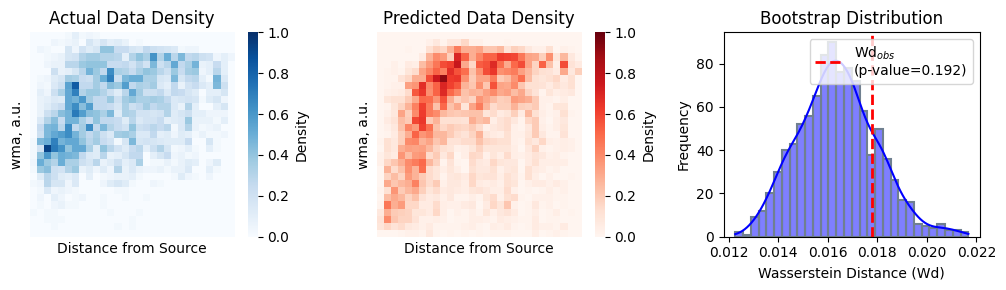

In [48]:
wd_cal(stats_cfd_slow.log_avg_dist_from_source, stats_cfd_slow.wf, stats_cosmos_slow_matched.log_avg_dist_from_source, stats_cosmos_slow_matched.wf, 'wf, hz', 0,1)
wd_cal(stats_cfd_slow.log_avg_dist_from_source, stats_cfd_slow.log_whiff, stats_cosmos_slow_matched.log_avg_dist_from_source, stats_cosmos_slow_matched.log_whiff, 'wd, s', 0,1)
wd_cal(stats_cfd_slow.log_avg_dist_from_source, stats_cfd_slow.mean_concentration, stats_cosmos_slow_matched.log_avg_dist_from_source, stats_cosmos_slow_matched.mean_concentration, 'wc, a.u.', 0,1)
wd_cal(stats_cfd_slow.log_avg_dist_from_source, stats_cfd_slow.std_whiff, stats_cosmos_slow_matched.log_avg_dist_from_source, stats_cosmos_slow_matched.std_whiff, 'wsd, a.u.', 0,1)
wd_cal(stats_cfd_slow.log_avg_dist_from_source, stats_cfd_slow.whiff_ma, stats_cosmos_slow_matched.log_avg_dist_from_source, stats_cosmos_slow_matched.whiff_ma, 'wma, a.u.', 0,1)

100%|██████████| 1000/1000 [00:01<00:00, 744.31it/s]


(0.019218937701353685, 0.013)

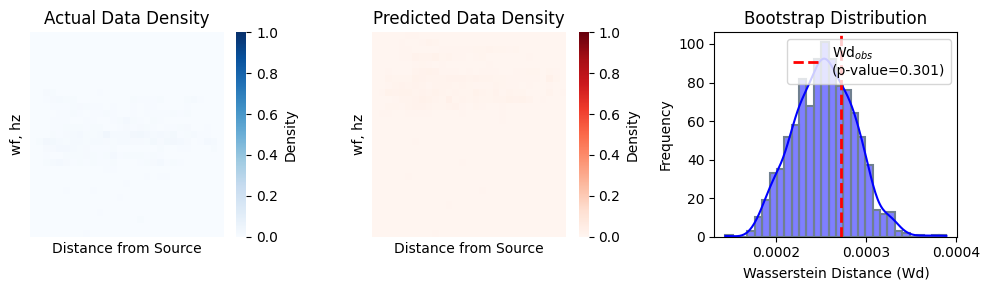

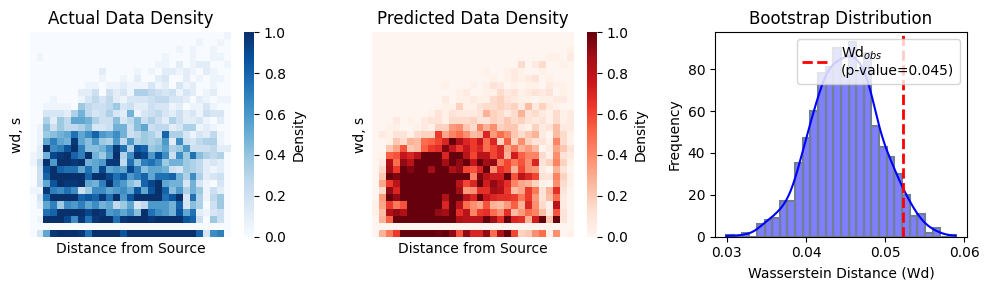

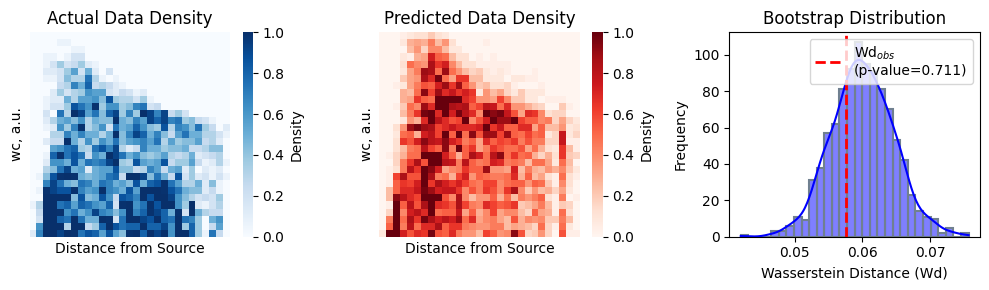

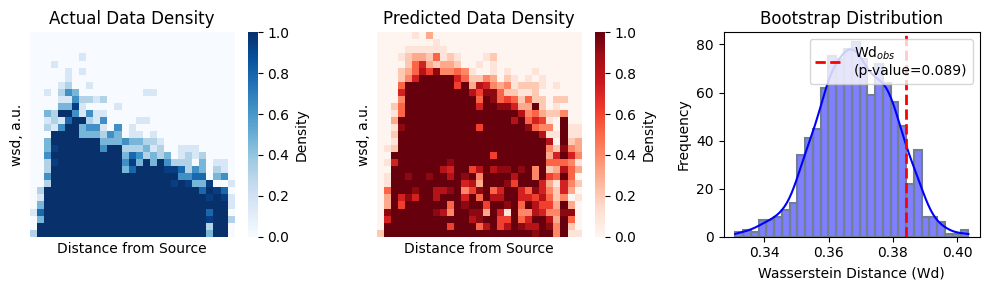

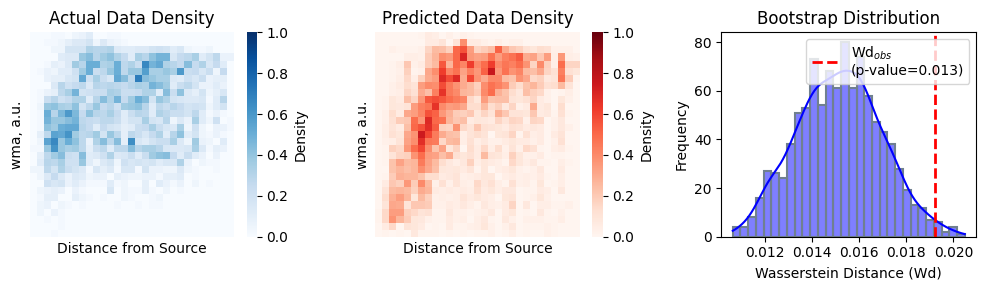

In [49]:
wd_cal(stats_cfd_fast.log_avg_dist_from_source, stats_cfd_fast.wf, stats_cosmos_fast_mismatched.log_avg_dist_from_source, stats_cosmos_fast_mismatched.wf, 'wf, hz', 0,1)
wd_cal(stats_cfd_fast.log_avg_dist_from_source, stats_cfd_fast.log_whiff, stats_cosmos_fast_mismatched.log_avg_dist_from_source, stats_cosmos_fast_mismatched.log_whiff, 'wd, s', 0,1)
wd_cal(stats_cfd_fast.log_avg_dist_from_source, stats_cfd_fast.mean_concentration, stats_cosmos_fast_mismatched.log_avg_dist_from_source, stats_cosmos_fast_mismatched.mean_concentration, 'wc, a.u.', 0,1)
wd_cal(stats_cfd_fast.log_avg_dist_from_source, stats_cfd_fast.std_whiff, stats_cosmos_fast_mismatched.log_avg_dist_from_source, stats_cosmos_fast_mismatched.std_whiff, 'wsd, a.u.', 0,1)
wd_cal(stats_cfd_fast.log_avg_dist_from_source, stats_cfd_fast.whiff_ma, stats_cosmos_fast_mismatched.log_avg_dist_from_source, stats_cosmos_fast_mismatched.whiff_ma, 'wma, a.u.', 0,1)

Bootstrapping null distribution... (n=500)
Generating figure...


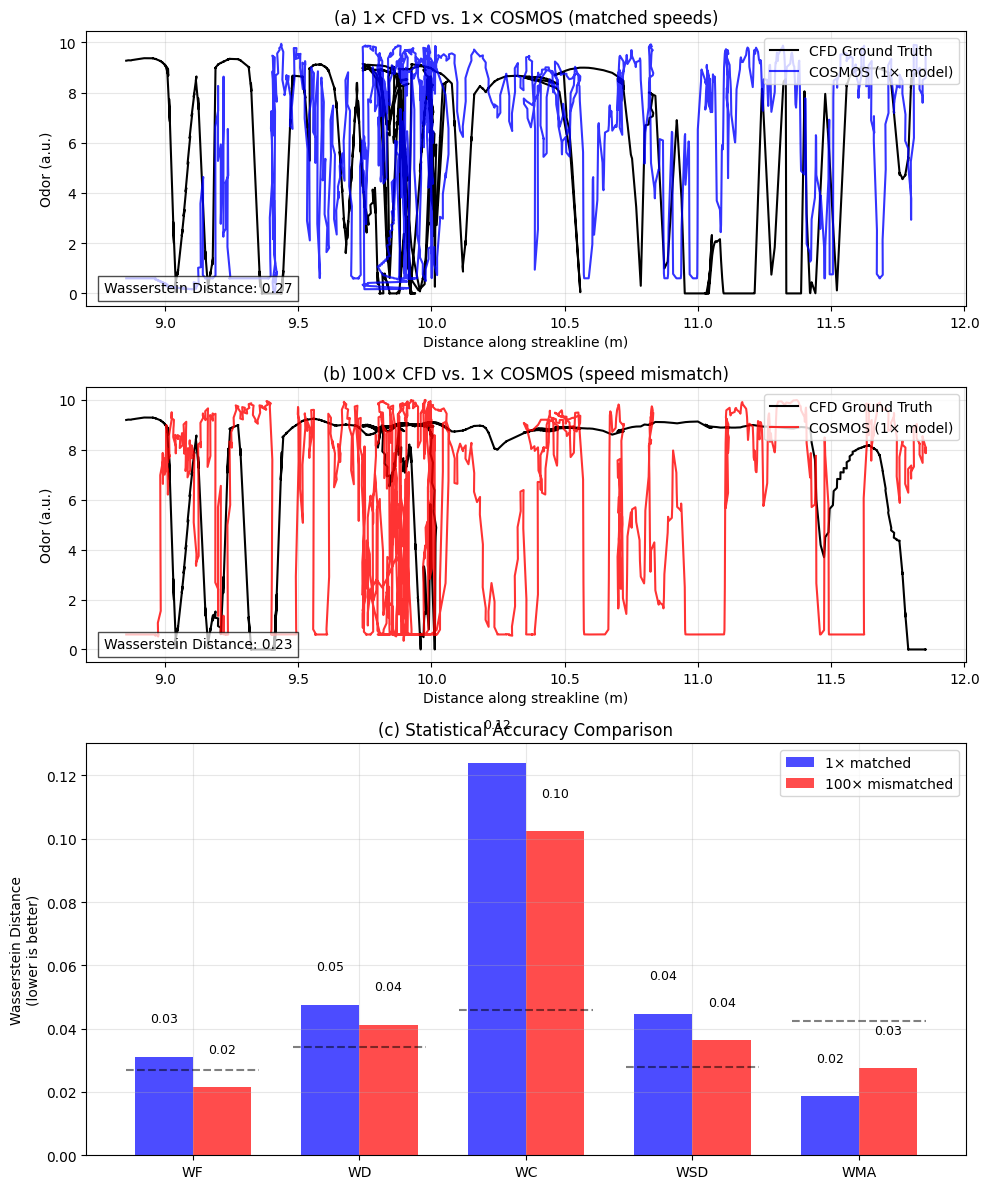


Wasserstein distances – CFD vs. COSMOS (lower is better)

                     WF      WD      WC     WSD     WMA       Σ
---------------------------------------------------------------
     1× Matched    0.03    0.05    0.12    0.04    0.02    0.27
100× Mismatched    0.02    0.04    0.10    0.04    0.03    0.23
     Null (95%)    0.03    0.03    0.05    0.03    0.04    0.18

Speed mismatch causes -14.0% increase in statistical error (Wasserstein distance)
The mismatched case exceeds the 95% confidence interval of the null distribution,
indicating statistically significant degradation in model performance.

Done.


In [30]:

# Calculate boostrap null distribution (used for statistical significance)
print(f"Bootstrapping null distribution... (n={N_BOOT})")
null_dist = {m: [] for m in METRICS}
for _ in range(N_BOOT):
    idx = np.random.permutation(len(stats_cfd_slow))
    half = len(idx) // 2
    a, b = stats_cfd_slow.iloc[idx[:half]], stats_cfd_slow.iloc[idx[half:]]
    for m, (xcol, ycol) in METRICS.items():
        null_dist[m].append(wd_2d(a[xcol], a[ycol], b[xcol], b[ycol]))
null_95 = {m: np.percentile(null_dist[m], 95) for m in METRICS}
null_95["SUM"] = sum(null_95.values())

# -----------------------------------------------------------------------------
#  7.  Create figure for paper
# -----------------------------------------------------------------------------
print("Generating figure...")

# Prepare data for time series plots
cum_d_slow = np.abs(df_cfd_slow.distance_along_streakline - df_cfd_slow.distance_along_streakline.iloc[0]).values
cum_d_fast = np.abs(df_cfd_fast.distance_along_streakline - df_cfd_fast.distance_along_streakline.iloc[0]).values
n_slow = np.argmax(cum_d_slow > DIST_WIN) or len(df_cfd_slow)
n_fast = np.argmax(cum_d_fast > DIST_WIN) or len(df_cfd_fast)

# Create a three-panel figure
fig, axs = plt.subplots(3, 1, figsize=(10, 12), gridspec_kw={"height_ratios": [1, 1, 1.5]})

# Panel A: 1× CFD vs. 1× COSMOS (slow model)
axs[0].plot(df_cfd_slow.distance_along_streakline.iloc[:n_slow], df_cfd_slow.odor.iloc[:n_slow], 
          'k-', label='CFD Ground Truth', linewidth=1.5)
axs[0].plot(df_cosmos_slow_matched.distance_along_streakline.iloc[:n_slow], df_cosmos_slow_matched.odor.iloc[:n_slow], 
          'b-', label='COSMOS (1× model)', linewidth=1.5, alpha=0.8)
axs[0].set_title('(a) 1× CFD vs. 1× COSMOS (matched speeds)')
axs[0].set_ylabel('Odor (a.u.)')
axs[0].set_xlabel('Distance along streakline (m)')
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc='upper right')
axs[0].text(0.02, 0.05, f'Wasserstein Distance: {wd_slow_matched["SUM"]:.2f}', 
          transform=axs[0].transAxes, bbox=dict(facecolor='white', alpha=0.7))

# Panel B: 100× CFD vs. 1× COSMOS (mismatched)
axs[1].plot(df_cfd_fast.distance_along_streakline.iloc[:n_fast], df_cfd_fast.odor.iloc[:n_fast], 
          'k-', label='CFD Ground Truth', linewidth=1.5)
axs[1].plot(df_cosmos_fast_mismatched.distance_along_streakline.iloc[:n_fast], df_cosmos_fast_mismatched.odor.iloc[:n_fast], 
          'r-', label='COSMOS (1× model)', linewidth=1.5, alpha=0.8)
axs[1].set_title('(b) 100× CFD vs. 1× COSMOS (speed mismatch)')
axs[1].set_ylabel('Odor (a.u.)')
axs[1].set_xlabel('Distance along streakline (m)')
axs[1].grid(True, alpha=0.3)
axs[1].legend(loc='upper right')
axs[1].text(0.02, 0.05, f'Wasserstein Distance: {wd_fast_mismatched["SUM"]:.2f}', 
          transform=axs[1].transAxes, bbox=dict(facecolor='white', alpha=0.7))

# Panel C: Bar chart comparing Wasserstein distances
metrics = list(METRICS.keys())
x = np.arange(len(metrics))
width = 0.35

matched_bars = axs[2].bar(x - width/2, [wd_slow_matched[m] for m in metrics], width, 
                       label='1× matched', color='blue', alpha=0.7)
mismatched_bars = axs[2].bar(x + width/2, [wd_fast_mismatched[m] for m in metrics], width, 
                           label='100× mismatched', color='red', alpha=0.7)

# Add null distribution threshold line for reference
for i, m in enumerate(metrics):
    axs[2].plot([i-0.4, i+0.4], [null_95[m], null_95[m]], 'k--', alpha=0.5)

axs[2].set_ylabel('Wasserstein Distance\n(lower is better)')
axs[2].set_title('(c) Statistical Accuracy Comparison')
axs[2].set_xticks(x)
axs[2].set_xticklabels(metrics)
axs[2].legend(loc='upper right')
axs[2].grid(True, alpha=0.3)

# Add value labels on bars
for bar in matched_bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
              f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
for bar in mismatched_bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
              f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('speed_mismatch_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# -----------------------------------------------------------------------------
#  8.  Print summary table and conclusions
# -----------------------------------------------------------------------------
print("\nWasserstein distances – CFD vs. COSMOS (lower is better)\n")
rows = [
    ("1× Matched", wd_slow_matched),
    ("100× Mismatched", wd_fast_mismatched),
    ("Null (95%)", null_95),
]

hdr = "{:>15}" + "{:>8}" * len(METRICS) + "{:>8}"
print(hdr.format("", *METRICS.keys(), "Σ"))
print("-" * (15 + 8 * (len(METRICS) + 1)))

for name, row in rows:
    vals = [row[m] for m in metrics]
    print(hdr.format(name, *[f"{v:6.2f}" for v in vals], f"{sum(vals):6.2f}"))

# Calculate percent change from matched to mismatched
pct_increase = (wd_fast_mismatched["SUM"] - wd_slow_matched["SUM"]) / wd_slow_matched["SUM"] * 100
print(f"\nSpeed mismatch causes {pct_increase:.1f}% increase in statistical error (Wasserstein distance)")

# Check if mismatched case exceeds null distribution
if wd_fast_mismatched["SUM"] > null_95["SUM"]:
    print("The mismatched case exceeds the 95% confidence interval of the null distribution,")
    print("indicating statistically significant degradation in model performance.")

print("\nDone.")

Collect Slow and Fast Data

In [ ]:
# Load base trajectory
dirname = '../data/simulator/rigolli/'
hmap_data = np.load(str(dirname) + "hmap.npz")
fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')
df_test=pd.read_hdf('/home/gorilla/An/data/simulator/plot/Figure_rigolli/rigolli_jan22.h5')

traj_ref = df_test.copy()
traj_ref = df_test.copy()
t0 = traj_ref['time'].min()
T  = traj_ref['time'].max() - t0

# linearly map [t0, t0+T] → [0, 170]
traj_ref['time'] = (traj_ref['time'] - t0) / T * 170
# Function to resample trajectory with different speeds
dt_base = traj_ref.time.diff().median()  # Typically 0.005s (200Hz)

def resample_traj(df, speed_factor):
    """
    Keep the SAME spatial path but change time-spacing so the agent
    traverses it faster (>1) or slower (<1).
    """
    new_dt = dt_base / speed_factor
    n = len(df)
    new_time = np.arange(0, n*new_dt, new_dt)[:n]
    out = df.copy()
    out['time'] = new_time
    return out

def make_faster_by_stride(df, stride):
    out = df.iloc[::stride, :].reset_index(drop=True).copy()
    out['time'] = np.arange(len(out)) * dt_base   # keep 5-ms grid
    return out

# # Create trajectories at different speeds
traj_fast = resample_traj(traj_ref, speed_factor=10)  # 5× faster
# traj_slow = resample_traj(traj_ref, speed_factor=0.5)  # 2× slower
traj_slow = traj_ref.copy()
# traj_fast = traj_ref.copy(); traj_fast.time *= 0.5

# traj_slow = traj_ref.copy(); traj_slow.time *= 2.0

# Function to run trajectories through CFD and get ground truth odor
def get_cfd_odor(traj, cfd):
    """Get ground truth odor from CFD, sampling exactly at traj.time."""
    odor = []
    for t, (x, y) in zip(
        traj.time.values,
        traj[['distance_along_streakline','nearest_from_streakline']].values
    ):
        odor.append(
            cfd.get_odor_at_position_and_time(
                (x, y),
                t
            )
        )
    out = traj.copy()
    out['odor'] = scale_data(odor)
    return out


# Function to run trajectories through COSMOS
def get_cosmos_odor(traj, hmap_data, fdf, fdf_nowhiff):
    """Run COSMOS prediction on a trajectory"""
    # Extract required parameters
    test_locations = traj[['distance_along_streakline', 'nearest_from_streakline']].values
    fitted_p_heatmap = hmap_data['fitted_p_heatmap']
    xedges = hmap_data['xedges']
    yedges = hmap_data['yedges']
    
    # Create predictor
    predictor = COSMOSBatch(
        fitted_p_heatmap=fitted_p_heatmap,
        xedges=xedges,
        yedges=yedges,
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff,
        test_locations=test_locations
    )
    
    # Get results
    results = predictor.predict()
    
    # Create output dataframe with predictions
    result_df = traj.copy()
    result_df['predicted_odor'] = results['concentrations']
    result_df['whiff_predicted'] = results['predictions']
    return result_df

# Load CFD simulator
cfd = Cfd_rigolli_BDCATS(dirname="../data/rigolli/")

# Get ground truth odor for both trajectories
print("Getting CFD ground truth for different speeds...")
cfd_fast = get_cfd_odor(traj_fast, cfd)
cfd_slow = get_cfd_odor(traj_slow, cfd)


In [ ]:
print("Running COSMOS predictions for different speeds...")
cosmos_fast = get_cosmos_odor(traj_fast, hmap_data, fdf_fast, fdf_nowhiff_fast)
cosmos_slow = get_cosmos_odor(traj_slow, hmap_data, fdf, fdf_nowhiff)

In [ ]:
# from itertools import groupby
# from operator import itemgetter

# def avg_distance(df,index,dat): #input ; location ; storage
#     i = 0
#     distance_along_streakline = []
#     nearest_from_streakline = []
#     while i<len(index):
#         distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
#         nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
#         i+=1
#     dat['avg_distance_along_streakline']= distance_along_streakline
#     dat['avg_nearest_from_streakline'] = nearest_from_streakline

# def get_index_nowhiff(data, th):
#     idx = [i for i, value in enumerate(data) if value < th]
#     index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
#     return index

# def avg_distance_nowhiff(df, idx, dat):
#     distance_along_streakline = []
#     nearest_from_streakline = []
#     for indices in idx:
#         if indices:  # Check if indices list is not empty
#             distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
#             nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
#         else:
#             distance_along_streakline.append(np.nan)
#             nearest_from_streakline.append(np.nan)

#     dat['avg_distance_along_streakline'] = distance_along_streakline
#     dat['avg_nearest_from_streakline'] = nearest_from_streakline

# def wc_wsd_nowhiff(df, idx, dat):
#     wc_nowhiff = []
#     std_dev_nowhiff = []
#     for indices in idx:
#         if indices:  # Check if indices list is not empty
#             wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
#             std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
#         else:
#             wc_nowhiff.append(np.nan)
#             std_dev_nowhiff.append(np.nan)

#     dat['wc_nowhiff'] = wc_nowhiff
#     dat['wsd_nowhiff'] = std_dev_nowhiff

# def cal_stat(df,idx,df2):
#     osc.avg_distance(df,idx,df2)
#     osc.mean_conc(df,idx,df2)
#     osc.whiff_blank_duration(df,idx,df2)
#     osc.std_whiff(df,idx,df2)
#     osc.mean_avg(df,idx,df2)
#     osc.encounter_frequency(df,idx,df2,1,2)
#     osc.mean_t(df,idx,df2)

# th = 6.5
# np.seterr(divide='ignore')
# index = osc.get_index(cfd_fast.odor,th)
# index_nowhiff = get_index_nowhiff(cfd_fast.odor,th)
# fdf_fast = pd.DataFrame()
# fdf_nowhiff_fast=pd.DataFrame()

# cal_stat(cfd_fast,index,fdf_fast)
# avg_distance(cfd_fast, index, fdf_fast)
# wc_wsd_nowhiff(cfd_fast, index_nowhiff,fdf_nowhiff_fast)
# avg_distance_nowhiff(cfd_fast,index_nowhiff,fdf_nowhiff_fast)

Running COSMOS predictions for different speeds...


In [29]:
# cfd_fast.to_hdf('/home/gorilla/An/data/simulator/speed_track/cfd_fast.h5', key='cfd_fast', mode='w')
# cfd_slow.to_hdf('/home/gorilla/An/data/simulator/speed_track/cfd_slow.h5', key='cfd_slow', mode='w')
# cosmos_fast.to_hdf('/home/gorilla/An/data/simulator/speed_track/cosmos_fast.h5', key='cosmos_fast', mode='w')
# cosmos_slow.to_hdf('/home/gorilla/An/data/simulator/speed_track/cosmos_slow.h5', key='cosmos_slow', mode='w')
# dir_1 = '/home/gorilla/An/data/simulator/speed_track/'
# cfd_fast=pd.DataFrame(str(dir_1) + 'cfd_fast.h5')
# cfd_slow=pd.DataFrame(str(dir_1) + 'cfd_slow.h5')
# cosmos_fast=pd.DataFrame(str(dir_1) + 'cosmos_fast.h5')
# cosmos_slow=pd.DataFrame(str(dir_1) + 'cosmos_slow.h5')

In [85]:
# Define threshold for whiff detection
th = 6.5  # Or use 6.5 for Rigolli

# Calculate statistics for all four datasets
print("Calculating statistics...")

# Calculate stats for all four conditions
fdf_cfd_fast = pd.DataFrame()
index_cfd_fast = osc.get_index(cfd_fast.odor, th)
cal_stat(cfd_fast, index_cfd_fast, fdf_cfd_fast)

fdf_cosmos_fast = pd.DataFrame()
index_cosmos_fast = osc.get_index(cosmos_fast.predicted_odor, th)
cal_stat_predicted(cosmos_fast, index_cosmos_fast, fdf_cosmos_fast) 

fdf_cfd_slow = pd.DataFrame()
index_cfd_slow = osc.get_index(cfd_slow.odor, th)
cal_stat(cfd_slow, index_cfd_slow, fdf_cfd_slow)

fdf_cosmos_slow = pd.DataFrame()
index_cosmos_slow = osc.get_index(cosmos_slow.predicted_odor, th)
cal_stat_predicted(cosmos_slow, index_cosmos_slow, fdf_cosmos_slow)


Calculating statistics...


/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1
/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


In [86]:

def get_wasserstein(x_true, y_true, x_pred, y_pred):
    """Calculate Wasserstein distance between two 2D distributions without plotting"""
    x_bins = np.linspace(min(x_true.min(), x_pred.min()), max(x_true.max(), x_pred.max()), 30)
    y_bins = np.linspace(min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max()), 30)
    
    # Compute 2D histograms (normalized)
    true_hist, _, _ = np.histogram2d(x_true, y_true, bins=[x_bins, y_bins], density=True)
    pred_hist, _, _ = np.histogram2d(x_pred, y_pred, bins=[x_bins, y_bins], density=True)
    true_hist = true_hist / true_hist.max()
    pred_hist = pred_hist / pred_hist.max()
    
    # Flatten the histograms for Wasserstein computation
    true_flat = true_hist.flatten()
    pred_flat = pred_hist.flatten()
    
    # Calculate observed 2D Wasserstein Distance
    observed_wd_2d = wasserstein_distance(true_flat, pred_flat)
    
    return observed_wd_2d


# Calculate Wasserstein distances for each metric
# Fast trajectory
w_fast_wf = get_wasserstein(
    fdf_cfd_fast.log_avg_dist_from_source, fdf_cfd_fast.wf, 
    fdf_cosmos_fast.log_avg_dist_from_source, fdf_cosmos_fast.wf
)

w_fast_wd = get_wasserstein(
    fdf_cfd_fast.log_avg_dist_from_source, fdf_cfd_fast.log_whiff, 
    fdf_cosmos_fast.log_avg_dist_from_source, fdf_cosmos_fast.log_whiff
)

w_fast_wc = get_wasserstein(
    fdf_cfd_fast.log_avg_dist_from_source, fdf_cfd_fast.mean_concentration, 
    fdf_cosmos_fast.log_avg_dist_from_source, fdf_cosmos_fast.mean_concentration
)

w_fast_wsd = get_wasserstein(
    fdf_cfd_fast.log_avg_dist_from_source, fdf_cfd_fast.std_whiff, 
    fdf_cosmos_fast.log_avg_dist_from_source, fdf_cosmos_fast.std_whiff
)

w_fast_wma = get_wasserstein(
    fdf_cfd_fast.log_avg_dist_from_source, fdf_cfd_fast.whiff_ma, 
    fdf_cosmos_fast.log_avg_dist_from_source, fdf_cosmos_fast.whiff_ma
)

# Slow trajectory
w_slow_wf = get_wasserstein(
    fdf_cfd_slow.log_avg_dist_from_source, fdf_cfd_slow.wf, 
    fdf_cosmos_slow.log_avg_dist_from_source, fdf_cosmos_slow.wf
)

w_slow_wd = get_wasserstein(
    fdf_cfd_slow.log_avg_dist_from_source, fdf_cfd_slow.log_whiff, 
    fdf_cosmos_slow.log_avg_dist_from_source, fdf_cosmos_slow.log_whiff
)

w_slow_wc = get_wasserstein(
    fdf_cfd_slow.log_avg_dist_from_source, fdf_cfd_slow.mean_concentration, 
    fdf_cosmos_slow.log_avg_dist_from_source, fdf_cosmos_slow.mean_concentration
)

w_slow_wsd = get_wasserstein(
    fdf_cfd_slow.log_avg_dist_from_source, fdf_cfd_slow.std_whiff, 
    fdf_cosmos_slow.log_avg_dist_from_source, fdf_cosmos_slow.std_whiff
)

w_slow_wma = get_wasserstein(
    fdf_cfd_slow.log_avg_dist_from_source, fdf_cfd_slow.whiff_ma, 
    fdf_cosmos_slow.log_avg_dist_from_source, fdf_cosmos_slow.whiff_ma
)

# Now we can calculate totals
w_fast_total = w_fast_wf + w_fast_wd + w_fast_wc + w_fast_wsd + w_fast_wma
w_slow_total = w_slow_wf + w_slow_wd + w_slow_wc + w_slow_wsd + w_slow_wma

# Print summary
print("\nWasserstein Distances (lower is better):")
print(f"Fast trajectory: {w_fast_total:.3f}")
print(f"Slow trajectory: {w_slow_total:.3f}")
print(f"Degradation due to speed: {(w_fast_total-w_slow_total)/w_slow_total*100:.1f}%")

# Create dictionaries for easier access
w_fast = {
    'WF': w_fast_wf,
    'WD': w_fast_wd,
    'WC': w_fast_wc,
    'WSD': w_fast_wsd,
    'WMA': w_fast_wma
}

w_slow = {
    'WF': w_slow_wf,
    'WD': w_slow_wd,
    'WC': w_slow_wc,
    'WSD': w_slow_wsd,
    'WMA': w_slow_wma
}

# Print per-metric degradation
print("\nPer-metric degradation:")
for metric in w_fast.keys():
    degradation = (w_fast[metric] - w_slow[metric]) / w_slow[metric] * 100
    print(f"{metric}: {degradation:.1f}%")


Wasserstein Distances (lower is better):
Fast trajectory: 0.468
Slow trajectory: 0.187
Degradation due to speed: 150.0%

Per-metric degradation:
WF: 50.1%
WD: 504.5%
WC: 91.1%
WSD: -38.4%
WMA: 482.2%


/tmp/ipykernel_142601/200940857.py:16: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax1.grid(False, alpha=0.3)
/tmp/ipykernel_142601/200940857.py:41: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax3.grid(False, alpha=0.3)


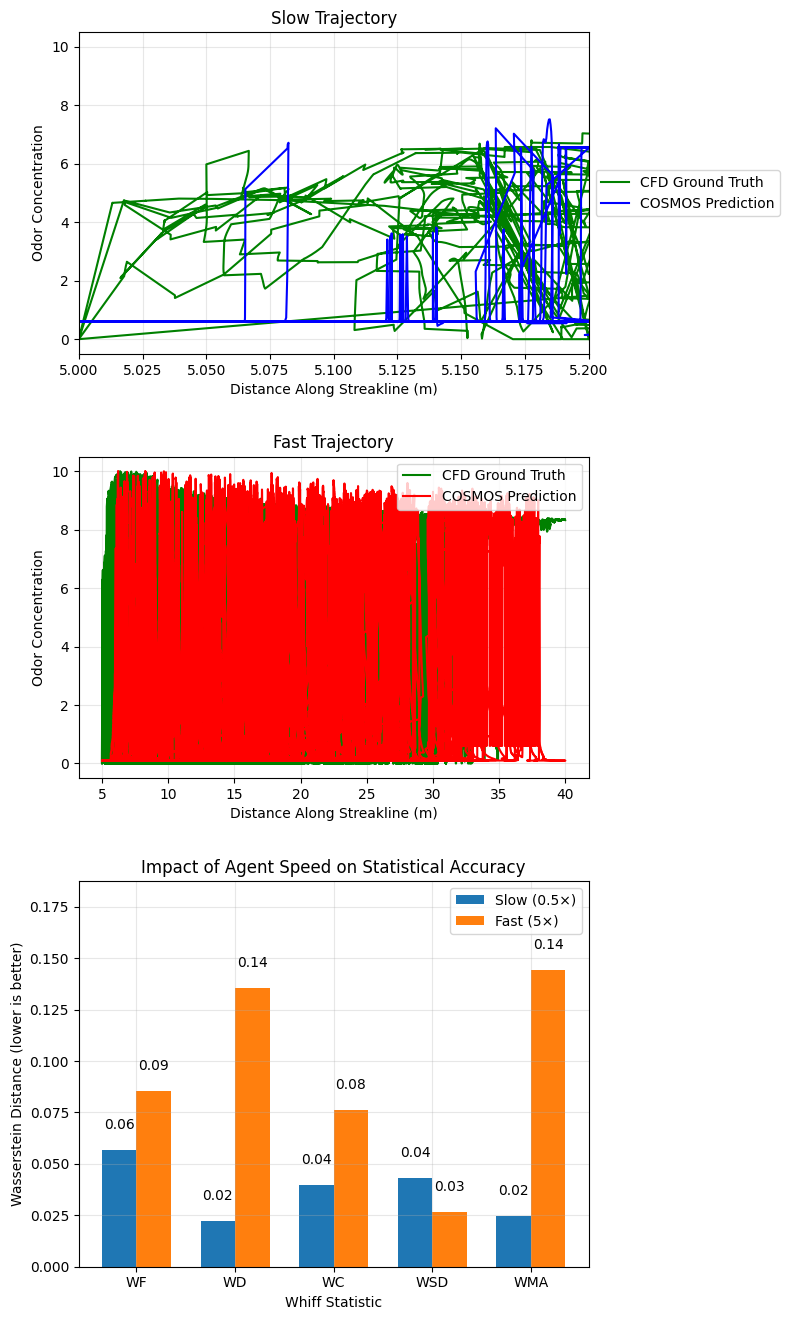

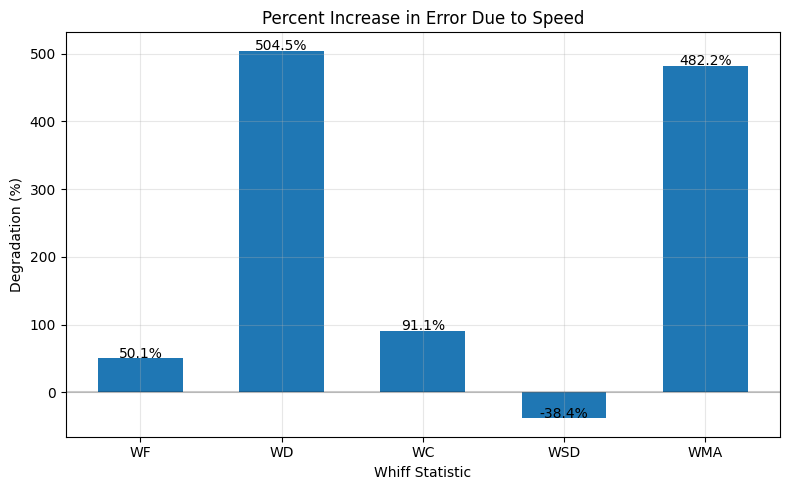

In [98]:


# # Choose a segment for visualization
# sample_length = 1000  # 5 seconds at 200Hz
# slow_idx = slice(0, sample_length)
# fast_idx = slice(0, sample_length//2)  # Half the points for same distance


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 14), gridspec_kw={'height_ratios': [1, 1, 1.2]})

# Subplot 1: Time series comparison - Slow Trajectory
ax1.plot(cfd_slow.distance_along_streakline, cfd_slow.odor, 'g-', label='CFD Ground Truth')
ax1.plot(cosmos_slow.distance_along_streakline, cosmos_slow.predicted_odor, 'b-', label='COSMOS Prediction')
ax1.set_title('Slow Trajectory')
ax1.set_xlabel('Distance Along Streakline (m)')
ax1.set_ylabel('Odor Concentration')
ax1.set_xlim(5, 5.2)
ax1.grid(False, alpha=0.3)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Subplot 2: Time series comparison - Fast Trajectory
ax2.plot(cfd_fast.distance_along_streakline, cfd_fast.odor, 'g-', label='CFD Ground Truth')
ax2.plot(cosmos_fast.distance_along_streakline, cosmos_fast.predicted_odor, 'r-', label='COSMOS Prediction')
ax2.set_title('Fast Trajectory')
ax2.set_xlabel('Distance Along Streakline (m)')
ax2.set_ylabel('Odor Concentration')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Subplot 3: Bar chart of Wasserstein distances
metrics = list(w_fast.keys())
x = np.arange(len(metrics))
width = 0.35
bars1 = ax3.bar(x - width/2, [w_slow[m] for m in metrics], width, label='Slow (0.5×)')
bars2 = ax3.bar(x + width/2, [w_fast[m] for m in metrics], width, label='Fast (5×)')
ax3.set_xlabel('Whiff Statistic')
ax3.set_ylabel('Wasserstein Distance (lower is better)')
ax3.set_title('Impact of Agent Speed on Statistical Accuracy')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.grid(False, alpha=0.3)

# Add value labels above bars
for i, m in enumerate(metrics):
    ax3.text(i - width/2, w_slow[m] + 0.01, f"{w_slow[m]:.2f}", ha='center')
    ax3.text(i + width/2, w_fast[m] + 0.01, f"{w_fast[m]:.2f}", ha='center')

# Increase top margin for third subplot
ax3.set_ylim(0, max([max([w_slow[m] for m in metrics]), max([w_fast[m] for m in metrics])]) * 1.3)

# Add figure title with padding
# fig.suptitle('Impact of Agent Speed on COSMOS Accuracy', fontsize=16, y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Increase top padding

plt.subplots_adjust(hspace=0.3)  # Add more space between subplots

# Create a separate figure for degradation percentage
fig2, ax4 = plt.subplots(figsize=(8, 5))
degradations = [(w_fast[m] - w_slow[m]) / w_slow[m] * 100 for m in metrics]
bars3 = ax4.bar(x, degradations, width=0.6)
ax4.set_xlabel('Whiff Statistic')
ax4.set_ylabel('Degradation (%)')
ax4.set_title('Percent Increase in Error Due to Speed')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.grid(True, alpha=0.3)

# Add value labels above bars
for i, val in enumerate(degradations):
    ax4.text(i, val + 1, f"{val:.1f}%", ha='center')

# Add horizontal line at 0
ax4.axhline(y=0, color='k', linestyle='-', alpha=0.2)
fig2.tight_layout()

plt.show()

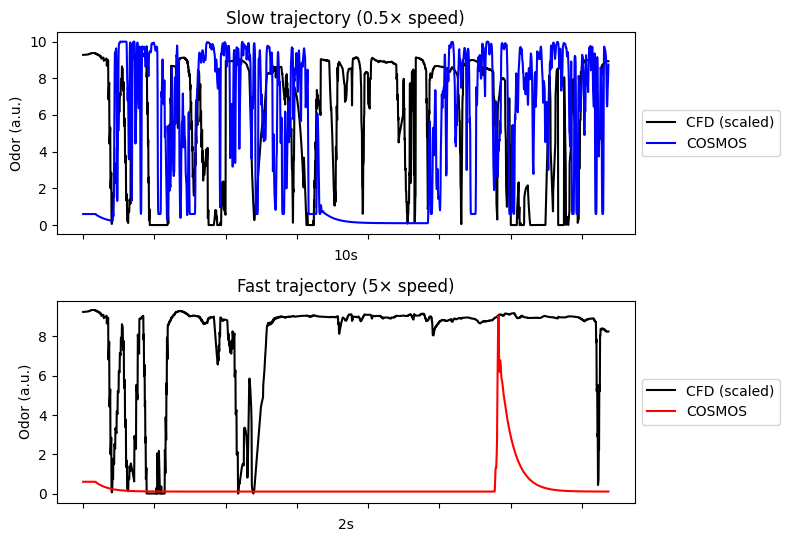

In [88]:
# choose the first 3 metres of travel for both speeds
dist_window = 3.0  # metres
cum_d_slow = np.abs(cfd_slow.distance_along_streakline -
                    cfd_slow.distance_along_streakline.iloc[0]).values
cum_d_fast = np.abs(cfd_fast.distance_along_streakline -
                    cfd_fast.distance_along_streakline.iloc[0]).values
n_slow = np.argmax(cum_d_slow > dist_window) or len(cfd_slow)
n_fast = np.argmax(cum_d_fast > dist_window) or len(cfd_fast)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=False)



# ---- slow -----------------------------------------------------------
axs[0].plot(cfd_slow.time.iloc[:n_slow], cfd_slow.odor.iloc[:n_slow], 'k-',  label='CFD (scaled)')
axs[0].plot(cosmos_slow.time.iloc[:n_slow], cosmos_slow.predicted_odor.iloc[:n_slow], 'b-', label='COSMOS')
axs[0].set_title('Slow trajectory (0.5× speed)')
axs[0].set_ylabel('Odor (a.u.)'); axs[0].grid(False); axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_xticklabels([])
axs[0].set_xlabel('10s')
# ---- fast -----------------------------------------------------------
axs[1].plot(cfd_fast.time.iloc[:n_fast], cfd_fast.odor.iloc[:n_fast], 'k-', label='CFD (scaled)')
axs[1].plot(cosmos_fast.time.iloc[:n_fast], cosmos_fast.predicted_odor.iloc[:n_fast],'r-', label='COSMOS')
axs[1].set_title('Fast trajectory (5× speed)')
axs[1].set_xlabel('Time (s)'); axs[1].set_ylabel('Odor (a.u.)')
axs[1].grid(False); axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[1].set_xticklabels([])
axs[1].set_xlabel('2s')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [91]:
th=6.5
query1 = 'odor>'+ str(th)
new_test_df1 = cosmos_slow.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+ str(th)
new_test_df2 = cosmos_fast.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)


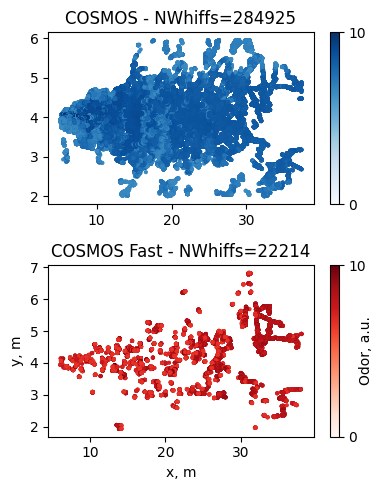

In [95]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Reds', vmin=0, vmax=10)
ax[0].set_title('COSMOS - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('COSMOS Fast - NWhiffs='+str(len(new_test_df2)))
# ax[0].set_title('Desert Data')
# ax[1].set_title('Simulated')
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')
cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-5)
cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# for i in range(2):
#     mpl_functions.adjust_spines(ax[i],['left','bottom'],
#                             spine_locations={'left': 1}, 
#                             smart_bounds=True,
#                             xticks=[0,25,50],
#                             yticks=[-15,0,15],
#                             linewidth=0.5)
#     mpl_functions.set_fontsize(ax[i],12)

f.tight_layout()

In [93]:
import seaborn as sns
from figurefirst import mpl_functions
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

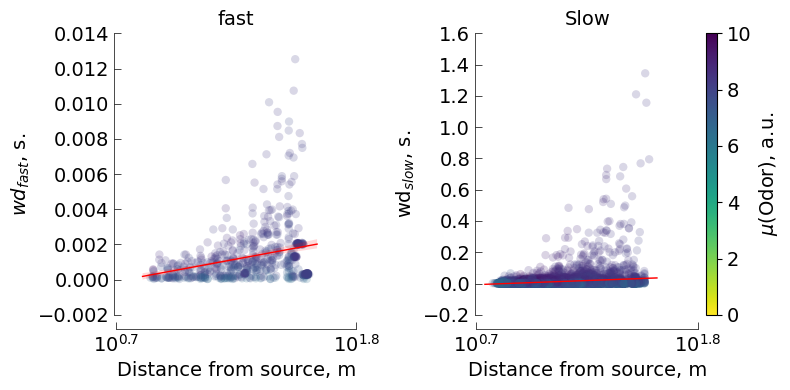

In [99]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf_cosmos_fast.log_avg_dist_from_source,fdf_cosmos_fast.length_of_encounter, c=fdf_cosmos_fast.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10)
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf_cosmos_fast.log_avg_dist_from_source,y=fdf_cosmos_fast.length_of_encounter , data=fdf_cosmos_fast,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('$wd_{fast}$, s.')
ax1.set_title('fast')
# ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_cosmos_slow.log_avg_dist_from_source,fdf_cosmos_slow.length_of_encounter, c=fdf_cosmos_slow.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_cosmos_slow.log_avg_dist_from_source,y=fdf_cosmos_slow.length_of_encounter , data=fdf_cosmos_slow,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Slow')
ax2.set_ylabel('wd$_{slow}$, s.')
# ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            # yticks=[-2.5,1.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            # yticks=[-2.5,1.5],
                            linewidth=0.5)
# ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax1.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])
# ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax2.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()
